In [1]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.optim import Adam
from data_loading import process_text_df, NewsText, tensorize_sentences, collate_fn
from tqdm import tqdm as pbar
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import matplotlib.pyplot as plt
import tqdm
stopwords = stopwords.words()
words = words.words() 
wordnet = wordnet.words()

In [2]:
fake, true = pd.read_csv('Fake.csv'), pd.read_csv('True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)

In [3]:
p1 = process_text_df(news, ['title', 'text'])

In [4]:
%%time
p1.process_text_col()

CPU times: user 3.1 s, sys: 1.38 s, total: 4.48 s
Wall time: 3min 45s


In [5]:
p1.tokenize_sentences()

In [6]:
p1.df

,title,text,subject,date,label
0,"[10293, 10292, 10291, 10290, 10289, 10288, 102...","[8561, 9233, 10221, 10293, 10292, 8944, 7577, ...",worldnews,"September 24, 2017",true
1,"[10285, 10284, 10283, 10282, 10281, 10280, 102...","[9336, 9233, 10221, 9026, 10285, 5586, 10284, ...",politicsNews,"November 12, 2017",true
2,"[10277, 10276, 10275]","[6094, 4127, 8910, 8609, 5853, 8348, 6366, 906...",News,"June 19, 2017",fake
3,"[10274, 10273, 10272, 0, 10271, 10270, 10269, ...","[5867, 9233, 10221, 0, 0, 10272, 10273, 2034, ...",worldnews,"October 7, 2017",true
4,"[10267, 10266, 10265, 10264, 10263, 10262, 102...","[0, 5379, 9026, 10285, 6719, 10249, 0, 8344, 1...",News,"May 15, 2016",fake
...,...,...,...,...,...
44893,"[5649, 9943, 8631, 0, 10173, 9553, 10007, 1022...","[1605, 5025, 7735, 10046, 10290, 6058, 0, 9945...",US_News,"April 1, 2016",fake
44894,"[9490, 9489, 5796, 0, 0, 0, 8815, 7938, 9279, ...","[9233, 10221, 1686, 5796, 0, 9490, 9489, 6765,...",politicsNews,"November 4, 2016",true
44895,"[9602, 9440, 8228, 10023, 10121, 6193, 7832]","[10007, 9233, 10221, 9166, 10188, 9602, 7522, ...",politicsNews,"September 28, 2017",true
44896,"[9479, 10246, 4368, 8574, 8576, 5888, 10246, 9...","[6956, 10226, 8720, 7456, 9892, 9445, 7576, 14...",left-news,"Feb 26, 2017",fake


In [7]:
l, labs = tensorize_sentences(p1.df.title, p1.df.label)

In [8]:
class LinearBlock(nn.Module):
    
    def __init__(self, layer_sequence, add_relu=False):
        super(LinearBlock, self).__init__()
        num_layers = len(layer_sequence) - 1
        layers = []
        names = []
        for i in range(num_layers):
            layers.append(nn.Linear(in_features=layer_sequence[i],
                                    out_features=layer_sequence[i + 1],
                                    bias=False)
                         )
            names.append(f'fc{i + 1}')
                
            if add_relu and i != num_layers - 1:
                layers.append(nn.ReLU())
                names.append(f'relu{i + 1}')
        
        self.module_dict = OrderedDict(zip(names, layers))
        self.block = nn.Sequential(self.module_dict)
        
    def forward(self, x):
        out = self.block(x)
        
        return out

In [9]:
class NewsNet(nn.Module):
    
    def __init__(self, vocab, hidden_size=10, embedding_dim=16, num_layers=2):
        super(NewsNet, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.word_embeddings = nn.Embedding(num_embeddings=len(vocab), embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            bias=False, 
                            hidden_size=self.hidden_size, 
                            batch_first=True,
                            num_layers=self.num_layers)
        self.linear_block = LinearBlock([self.hidden_size, self.hidden_size * 2, self.hidden_size, 1])
        
    def forward(self, s):
        
        out = self.word_embeddings(s)
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.linear_block(out)
        
        return out

In [17]:
net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
idx = len(l) // 4

l_tr, labs_tr = l[:-2 * idx], labs[: -2 * idx]
l_val, labs_val = l[-2 * idx:-idx], labs[-2 * idx:-idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
l_tr, l_val, labs_tr, labs_val = l[:idx], l[idx:], labs[:idx], labs[idx:]
tr_set = NewsText(l_tr, labs_tr)
val_set = NewsText(l_val, labs_val)
_, val_set = enumerate(DataLoader(val_set, batch_size=len(val_set), collate_fn=collate_fn)).__next__()
val_features, val_labels = val_set
val_labels = val_labels.unsqueeze(-1).float()
loader = DataLoader(tr_set, batch_size=4, collate_fn=collate_fn)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 80
for i in range(epochs):
    print(f'Epoch {i + 1}')
    for sents, labels in pbar(loader):
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
        
    loss_list.append(loss.item())

  1%|          | 30/2806 [00:00<00:09, 298.58it/s]

Epoch 1


  2%|▏         | 65/2806 [00:00<00:08, 321.53it/s]

Epoch 2


  1%|          | 32/2806 [00:00<00:08, 309.48it/s]

Epoch 3


  2%|▏         | 62/2806 [00:00<00:08, 305.19it/s]

Epoch 4


  1%|          | 30/2806 [00:00<00:09, 291.14it/s]

Epoch 5


  2%|▏         | 58/2806 [00:00<00:09, 282.18it/s]

Epoch 6


  1%|          | 28/2806 [00:00<00:10, 271.13it/s]

Epoch 7


  2%|▏         | 56/2806 [00:00<00:10, 274.07it/s]

Epoch 8


  1%|          | 28/2806 [00:00<00:10, 272.41it/s]

Epoch 9


  2%|▏         | 57/2806 [00:00<00:09, 276.79it/s]

Epoch 10


  1%|          | 28/2806 [00:00<00:10, 275.13it/s]

Epoch 11


  1%|          | 28/2806 [00:00<00:10, 274.76it/s]

Epoch 12


  1%|          | 28/2806 [00:00<00:10, 273.45it/s]

Epoch 13


  1%|          | 29/2806 [00:00<00:09, 280.70it/s]

Epoch 14


  2%|▏         | 57/2806 [00:00<00:09, 279.26it/s]

Epoch 15


  1%|          | 28/2806 [00:00<00:09, 278.09it/s]

Epoch 16


  1%|          | 29/2806 [00:00<00:09, 281.04it/s]

Epoch 17


  1%|          | 28/2806 [00:00<00:10, 277.01it/s]

Epoch 18


  2%|▏         | 57/2806 [00:00<00:09, 280.48it/s]

Epoch 19


  1%|          | 28/2806 [00:00<00:10, 269.75it/s]

Epoch 20


  1%|          | 28/2806 [00:00<00:10, 269.94it/s]

Epoch 21


  1%|          | 27/2806 [00:00<00:10, 268.55it/s]

Epoch 22


  2%|▏         | 55/2806 [00:00<00:10, 266.93it/s]

Epoch 23


  1%|          | 25/2806 [00:00<00:11, 242.55it/s]

Epoch 24


  1%|          | 28/2806 [00:00<00:10, 274.59it/s]

Epoch 25


  1%|          | 28/2806 [00:00<00:10, 271.10it/s]

Epoch 26


  2%|▏         | 55/2806 [00:00<00:10, 273.42it/s]

Epoch 27


  1%|          | 28/2806 [00:00<00:10, 274.12it/s]

Epoch 28


  1%|          | 28/2806 [00:00<00:10, 270.22it/s]

Epoch 29


  1%|          | 29/2806 [00:00<00:09, 280.52it/s]

Epoch 30


  1%|          | 28/2806 [00:00<00:09, 278.20it/s]

Epoch 31


  1%|          | 28/2806 [00:00<00:09, 278.49it/s]

Epoch 32


  1%|          | 28/2806 [00:00<00:10, 276.13it/s]

Epoch 33


  1%|          | 28/2806 [00:00<00:09, 279.57it/s]

Epoch 34


  1%|          | 28/2806 [00:00<00:10, 275.67it/s]

Epoch 35


  1%|          | 28/2806 [00:00<00:09, 279.85it/s]

Epoch 36


  2%|▏         | 56/2806 [00:00<00:10, 273.35it/s]

Epoch 37


  1%|          | 28/2806 [00:00<00:10, 274.10it/s]

Epoch 38


  1%|          | 28/2806 [00:00<00:10, 277.18it/s]

Epoch 39


  1%|          | 28/2806 [00:00<00:09, 277.99it/s]

Epoch 40


  2%|▏         | 56/2806 [00:00<00:09, 277.82it/s]

Epoch 41


  2%|▏         | 56/2806 [00:00<00:09, 277.98it/s]

Epoch 42


  2%|▏         | 56/2806 [00:00<00:09, 276.89it/s]

Epoch 43


  1%|          | 28/2806 [00:00<00:10, 271.19it/s]

Epoch 44


  1%|          | 27/2806 [00:00<00:10, 264.11it/s]

Epoch 45


  1%|          | 28/2806 [00:00<00:10, 273.33it/s]

Epoch 46


  1%|          | 28/2806 [00:00<00:10, 273.87it/s]

Epoch 47


  1%|          | 28/2806 [00:00<00:10, 276.88it/s]

Epoch 48


  1%|          | 28/2806 [00:00<00:10, 277.73it/s]

Epoch 49


  2%|▏         | 56/2806 [00:00<00:09, 275.11it/s]

Epoch 50


  1%|          | 28/2806 [00:00<00:09, 279.15it/s]

Epoch 51


  1%|          | 28/2806 [00:00<00:10, 277.37it/s]

Epoch 52


  2%|▏         | 56/2806 [00:00<00:09, 275.06it/s]

Epoch 53


  2%|▏         | 57/2806 [00:00<00:09, 280.48it/s]

Epoch 54


  1%|          | 29/2806 [00:00<00:09, 281.07it/s]

Epoch 55


  1%|          | 29/2806 [00:00<00:09, 282.20it/s]

Epoch 56


  2%|▏         | 56/2806 [00:00<00:09, 275.22it/s]

Epoch 57


  1%|          | 28/2806 [00:00<00:09, 279.26it/s]

Epoch 58


  2%|▏         | 56/2806 [00:00<00:09, 277.40it/s]

Epoch 59


  2%|▏         | 56/2806 [00:00<00:09, 277.46it/s]

Epoch 60


  1%|          | 28/2806 [00:00<00:09, 279.12it/s]

Epoch 61


  1%|          | 28/2806 [00:00<00:09, 279.36it/s]

Epoch 62


  1%|          | 27/2806 [00:00<00:10, 259.97it/s]

Epoch 63


  2%|▏         | 56/2806 [00:00<00:09, 277.79it/s]

Epoch 64


  2%|▏         | 56/2806 [00:00<00:09, 278.27it/s]

Epoch 65


  2%|▏         | 56/2806 [00:00<00:09, 275.53it/s]

Epoch 66


  2%|▏         | 56/2806 [00:00<00:09, 276.54it/s]

Epoch 67


  1%|          | 29/2806 [00:00<00:09, 281.33it/s]

Epoch 68


  1%|          | 28/2806 [00:00<00:10, 270.92it/s]

Epoch 69


  1%|          | 28/2806 [00:00<00:09, 279.90it/s]

Epoch 70


  1%|          | 28/2806 [00:00<00:09, 278.55it/s]

Epoch 71


  2%|▏         | 56/2806 [00:00<00:09, 275.45it/s]

Epoch 72


  2%|▏         | 56/2806 [00:00<00:09, 278.53it/s]

Epoch 73


  1%|          | 28/2806 [00:00<00:10, 273.88it/s]

Epoch 74


  1%|          | 28/2806 [00:00<00:10, 274.28it/s]

Epoch 75


  2%|▏         | 56/2806 [00:00<00:10, 274.60it/s]

Epoch 76


  2%|▏         | 53/2806 [00:00<00:10, 262.68it/s]

Epoch 77


  1%|          | 28/2806 [00:00<00:10, 277.37it/s]

Epoch 78


  1%|          | 28/2806 [00:00<00:10, 275.79it/s]

Epoch 79


  1%|          | 24/2806 [00:00<00:11, 237.70it/s]

Epoch 80


100%|██████████| 2806/2806 [00:09<00:00, 282.62it/s]


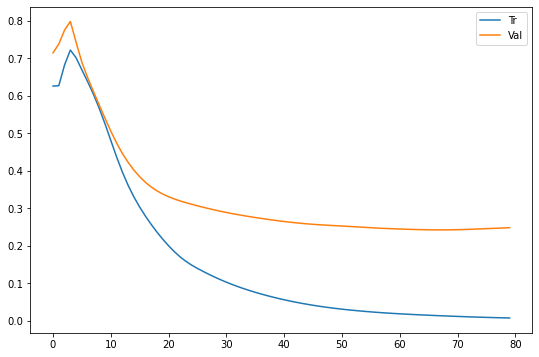

In [18]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

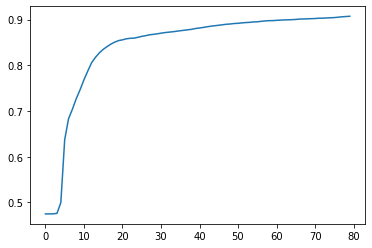

In [19]:
pd.Series(accuracy_list).plot()

In [20]:
tst_set = NewsText(l_tst, labs_tst)
_, tst_set = enumerate(DataLoader(tst_set, batch_size=len(tst_set), collate_fn=collate_fn)).__next__()
tst_features, tst_labels = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [21]:
with torch.no_grad():
    tst_out = net(tst_features)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [22]:
accuracy_tst

0.9054704308509827